<h1>Writing Like Shakespeare using Deep Learning</h1>
-Kashish
<h3>Problem Statement</h3>
We have a collection of Shakespeare' Sonnets, we want to build a Deep Learning System using a deep Recurrent Neural Network with a combination of Bidirectional-LSTMs and LSTMs that could help us generate similar poems.

<h3>Real-world/Business-objectives and constraints:</h3>

1. Minimize multi-class error.
2. Multi-class probability estimates.
3. Generating output should not take hours and block system resources. It should be efficient enough to work in a few seconds.

- All necessary imports are made when required and specific functions/attributes only.


<h3>Collecting the Data</h3>
<h4>Data</h4>

Our dataset contains a collection of Shakespeare' Sonnets, downloaded from the following link :
https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt

<h4>Data Sample</h4>

Shall sum my count and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.
Look in thy glass, and tell the face thou viewest
Now is the time that face should form another;
Whose fresh repair if now thou not renewest,
Thou dost beguile the world, unbless some mother.
For where is she so fair whose unear'd womb
Disdains the tillage of thy husbandry?


In [1]:
!wget --no-check-certificate \ https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \ -O sonnets.txt 

--2022-02-02 13:38:16--  http://%5C/
Resolving \\ (\\)... failed: No such host is known. .
wget: unable to resolve host address '\\'
--2022-02-02 13:38:16--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.194.112, 142.250.206.144, 142.250.194.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.194.112|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: 'sonnets.txt'

     0K .......... .......... .......... .......... .......... 54%  607K 0s
    50K .......... .......... .......... .......... .         100% 1.02M=0.1s

2022-02-02 13:38:18 (750 KB/s) - 'sonnets.txt' saved [93578/93578]

--2022-02-02 13:38:18--  http://%5C/
Resolving \\ (\\)... failed: No such host is known. .
wget: unable to resolve host address '\\'
FINISHED --2022-02-02 13:38:18--
Total w

<h4>Exploratory data Analysis</h4>


In [9]:
from tensorflow import data

dataset = data.TextLineDataset("sonnets.txt")

# count no. of lines in the dataset
raw_data = [element.decode("utf-8") for element in dataset.as_numpy_iterator()]
print("Number of lines in dataset: %s" % len(raw_data))

from tensorflow.keras.preprocessing.text import Tokenizer

# count no. of unique words in dataset
tokenizer = Tokenizer()
tokenizer.fit_on_texts(raw_data)
print("Number of unique words in dataset: %s" % len(tokenizer.word_index))
# find max and min no. of words in a sentence
tokenized_data = tokenizer.texts_to_sequences(raw_data)
lines_length = [len(sequence) for sequence in tokenized_data if len(sequence) > 1]
print(
    "Max number of words in a sentence: {}\nMin number of words in a sentence: {}".format(
        max(lines_length), min(lines_length)
    )
)


Number of lines in dataset: 2158
Number of unique words in dataset: 3210
Max number of words in a sentence: 11
Min number of words in a sentence: 5


In [ ]:
# #plot a graph
# from seaborn import displot
# from pandas import DataFrame
# from matplotlib.pyplot import grid

# temp_df=DataFrame({'n_lines':lines_length})
# temp_df=temp_df.n_lines.value_counts().reset_index()
# displot(lines_length,kind='hist',color='crimson',aspect=1,height=5)
# grid(True)


<h3>Prepare the data to feed to model for training</h3>
Steps:

1. Tokenizing the data, using a word Tokenizer.
2. Create n-gram sequences.
3. Pre-padding the sequences to make them of equal lengths.
4. Splitting the last word from each sentence to form label.

For example:

<li> Sentence: 'FROM fairest creatures we desire increase'</li><br>
<li> Step-1: [34, 417, 877, 166, 213, 517]</li><br>
<li> Step-2: Create n-gram sequences<br>&emsp;[[34, 417],
 <br>&emsp;[34, 417, 877],
 <br>&emsp;[34, 417, 877, 166],
 <br>&emsp;[34, 417, 877, 166, 213],
 <br>&emsp;[34, 417, 877, 166, 213, 517]]</li><br>
<li> Step-3: Pre-Padding the sequences to make them of equal lengths.
<br>&emsp;[  0,   0,   0,   0,   0,   0,   0,   0,   0,  34, 417],
<br>&emsp;[  0,   0,   0,   0,   0,   0,   0,   0,  34, 417, 877],
<br>&emsp;[  0,   0,   0,   0,   0,   0,   0,  34, 417, 877, 166],
<br>&emsp;[  0,   0,   0,   0,   0,   0,  34, 417, 877, 166, 213],
<br>&emsp;[  0,   0,   0,   0,   0,  34, 417, 877, 166, 213, 517]</li><br>
<li> Step-4: Final training sequences and labels.
<br>&emsp;[  0,   0,   0,   0,   0,   0,   0,   0,   0,  34, 417],&emsp; 417
<br>&emsp;[  0,   0,   0,   0,   0,   0,   0,   0,  34, 417, 877],&emsp; 877
<br>&emsp;[  0,   0,   0,   0,   0,   0,   0,  34, 417, 877, 166],&emsp; 166
<br>&emsp;[  0,   0,   0,   0,   0,   0,  34, 417, 877, 166, 213],&emsp; 213
<br>&emsp;[  0,   0,   0,   0,   0,  34, 417, 877, 166, 213, 517] &emsp; 517</li><br>


In [10]:
# tokenize the data using a word Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(raw_data)
tokenized_data = tokenizer.texts_to_sequences(raw_data)



In [11]:
# create n-grams
training_sequences = [
    sequence[:i] for sequence in tokenized_data for i in range(2, len(sequence) + 1)
]


In [12]:
# padding the data with zeros
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_sequences = pad_sequences(training_sequences)


In [18]:
# prepare the training data
x_train, y_train = padded_sequences[:, :-1], padded_sequences[:, -1]


<h3>Defining and Training the Model</h3>
We are using a Sequential model with the following layers:

1. Embedding
2. Bidirectional LSTM
3. Dropout
4. LSTM
5. Dense
6. Dense

The parameters used are:

<li> vocab_size=len(tokenizer.word_index)+1
<li> wv_dims=100
<li> input_length=x_train.shape[1]
<li> dropout_rate=0.2
<li> lstm_units=128
<li> regularization_rate=0.01
<li> epochs=50


In [43]:
# setting the parameters for model with Bidirectional LSTM and LSTM layers
vocab_size = len(tokenizer.word_index) + 1
wv_dims = 100
input_length = x_train.shape[1]
# dropout_rate = 0.2
# lstm_units = 128
# regularization_rate = 0.01
# epochs = 50



In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint


In [53]:
model = Sequential()
model.add(Embedding(vocab_size, wv_dims, input_length=input_length))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Dropout(rate=0.1))
model.add(LSTM(units=128))
model.add(
    Dense(units=vocab_size//4, activation="relu", activity_regularizer=regularizers.L2(l2=0.01),)
)
model.add(Dense(vocab_size, activation="softmax"))
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
# checkpoint = ModelCheckpoint(
    # "../Writing_like_shakespeare/sm_LSTM.weights.best.hdf5",
    # monitor="val_loss",
    # verbose=1,
    # save_best_only=True,
    # mode="min",
# )
model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 10, 100)           321100    
                                                                 
 bidirectional_12 (Bidirecti  (None, 10, 256)          234496    
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 10, 256)           0         
                                                                 
 lstm_25 (LSTM)              (None, 128)               197120    
                                                                 
 dense_24 (Dense)            (None, 802)               103458    
                                                                 
 dense_25 (Dense)            (None, 3211)              2578433   
                                                     

In [54]:
from tensorflow.keras.callbacks import TensorBoard

In [55]:
tensorboard_callback=TensorBoard(log_dir='../Writing_like_shakespeare/tb_logs')

In [56]:
# train the model
history = model.fit(
    x_train,
    y_train,
    batch_size=128,
    validation_split=0.2,
    verbose=1,
    epochs=50,
    callbacks=[tensorboard_callback],
)

Epoch 1/50
97/97 [==============================] - 32s 244ms/step - loss: 7.1143 - accuracy: 0.0209 - val_loss: 6.8480 - val_accuracy: 0.0162
Epoch 2/50
97/97 [==============================] - 23s 233ms/step - loss: 6.5859 - accuracy: 0.0222 - val_loss: 6.8415 - val_accuracy: 0.0178
Epoch 3/50
97/97 [==============================] - 21s 214ms/step - loss: 6.4471 - accuracy: 0.0275 - val_loss: 6.8435 - val_accuracy: 0.0220
Epoch 4/50
97/97 [==============================] - 21s 220ms/step - loss: 6.2957 - accuracy: 0.0310 - val_loss: 6.8949 - val_accuracy: 0.0200
Epoch 5/50
97/97 [==============================] - 22s 222ms/step - loss: 6.1781 - accuracy: 0.0340 - val_loss: 6.9839 - val_accuracy: 0.0230
Epoch 6/50
97/97 [==============================] - 21s 216ms/step - loss: 6.0572 - accuracy: 0.0397 - val_loss: 7.0964 - val_accuracy: 0.0314
Epoch 7/50
97/97 [==============================] - 21s 218ms/step - loss: 5.9218 - accuracy: 0.0452 - val_loss: 7.1848 - val_accuracy: 0.0255

In [57]:
model.save("../Writing_like_shakespeare/sm_LSTM.weights.best.hdf5")

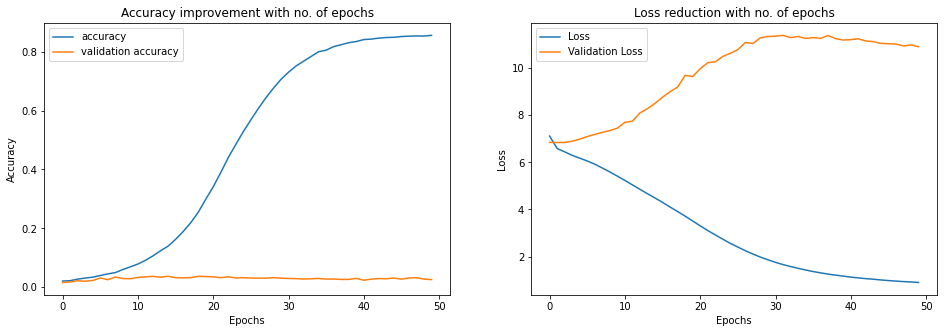

In [58]:
from matplotlib.pyplot import figure, plot, title, ylabel, xlabel, legend, subplot, show
figure(figsize=(16, 5))
subplot(121)
title("Accuracy improvement with no. of epochs")
plot(history.history["accuracy"])
plot(history.history["val_accuracy"])
ylabel("Accuracy")
xlabel("Epochs")
legend(["accuracy", "validation accuracy"])
subplot(122)
title("Loss reduction with no. of epochs")
plot(history.history["loss"])
plot(history.history["val_loss"])
ylabel("Loss")
xlabel("Epochs")
legend(["Loss","Validation Loss"])
show()


<h3>Generate text using learned model

In [13]:
#load the model
from tensorflow.keras.models import load_model
model=load_model("../Writing_like_shakespeare/sm_LSTM.weights.best.hdf5")

In [14]:
from numpy import argmax

In [16]:
def generate_text(seed_text,next_words):
    for _ in range(next_words):
        tokenized_string=tokenizer.texts_to_sequences([seed_text])[0]
        token_list=pad_sequences([tokenized_string],maxlen=x_train.shape[1])
        predicted= argmax(model.predict(token_list),axis=-1)
        output_word=""
        for word, index in tokenizer.word_index.items():
            if index== predicted:
                output_word=word
                break
        seed_text+=" "+output_word
    return seed_text

In [19]:
seed_text = "Oh once great men have fallen"
generate_text(seed_text=seed_text, next_words=50)


"Oh once great men have fallen hours with heaven's sweetest hand defaced in land fire and both rage alone is as mine eye may be decay so rare ' have often lived alone rotten ' with fullness cost and weeks weeks weeks weeks ' with fullness cover none ' ' ' ' ' ' ' '"

In [23]:
generate_text(" ' ",next_words=50)

" '  in 'twixt first a tomb the womb wherein they grew to prove none ' ' ' ' ' ' ' ' ' sadly fullness cost alone heaven expired gems gems gems gems gems gems rich aspect aspect gems gems gems day by eyes shall done shall see me no remedy"